In [11]:
import numpy as np
import wandb
from datasets import load_dataset
from transformers import AutoTokenizer
import tensorflow as tf
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import accuracy_score

In [12]:
dataset = load_dataset("silicone", "maptask")

Found cached dataset silicone (C:/Users/ilyes/.cache/huggingface/datasets/silicone/maptask/1.0.0/af617406c94e3f78da85f7ea74ebfbd3f297a9665cb54adbae305b03bc4442a5)


  0%|          | 0/3 [00:00<?, ?it/s]

In [13]:
# Separate the dataset into train val and test
train_dataset = dataset["train"]
val_dataset = dataset["validation"]
test_dataset = dataset["test"]

# Separate X (Utterance) and y (Dialogue_Act)
train_X = train_dataset["Utterance"]
train_y = train_dataset["Label"]

val_X = val_dataset["Utterance"]
val_y = val_dataset["Label"]

test_X = test_dataset["Utterance"]
test_y = test_dataset["Label"]

# Convert y from int to one-hot
# train_y = tf.keras.utils.to_categorical(train_y)
# val_y = tf.keras.utils.to_categorical(val_y)
# test_y = tf.keras.utils.to_categorical(test_y)

# convert train_y to array
train_y = np.array(train_y).reshape(-1, 1)
val_y = np.array(val_y).reshape(-1, 1)
test_y = np.array(test_y).reshape(-1, 1)

one_hot_encoder = OneHotEncoder(handle_unknown="ignore")
train_y = one_hot_encoder.fit_transform(train_y)
val_y = one_hot_encoder.transform(val_y)
test_y = one_hot_encoder.transform(test_y)

# convert train_y to list
train_y = train_y.toarray().tolist()
val_y = val_y.toarray().tolist()
test_y = test_y.toarray().tolist()

In [14]:
train_X[:5], train_y[:5]

(['okay the start part is at the top left-hand corner',
  'uh-huh',
  'okay',
  'uh-huh',
  "ehm you're coming the s-- for three inches down below that"],
 [[0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
  [1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
  [0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0],
  [0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]])

In [20]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from transformers import AutoTokenizer, TFBertModel 

tokenizer = AutoTokenizer.from_pretrained('bert-base-cased')
bert = TFBertModel.from_pretrained('bert-base-cased')

# Tokenize the data
train_encodings = tokenizer(train_X, truncation=True, padding=True)
val_encodings = tokenizer(val_X, truncation=True, padding=True)
test_encodings = tokenizer(test_X, truncation=True, padding=True)

# Pad val_encodings and test_encodings to 124
val_encodings['input_ids'] = tf.keras.preprocessing.sequence.pad_sequences(val_encodings['input_ids'], maxlen=124, dtype="long", value=0, truncating="post", padding="post")
# val_encodings['attention_mask'] = tf.keras.preprocessing.sequence.pad_sequences(val_encodings['attention_mask'], maxlen=124, dtype="long", value=0, truncating="post", padding="post")

test_encodings['input_ids'] = tf.keras.preprocessing.sequence.pad_sequences(test_encodings['input_ids'], maxlen=124, dtype="long", value=0, truncating="post", padding="post")
# test_encodings['attention_mask'] = tf.keras.preprocessing.sequence.pad_sequences(test_encodings['attention_mask'], maxlen=124, dtype="long", value=0, truncating="post", padding="post")

# Convert the data to tf dataset
# train_dataset = tf.data.Dataset.from_tensor_slices((
#     dict(train_encodings),
#     train_y
# ))

# val_dataset = tf.data.Dataset.from_tensor_slices((
#     dict(val_encodings),
#     val_y
# ))

# test_dataset = tf.data.Dataset.from_tensor_slices((
#     dict(test_encodings),
#     test_y
# ))

# Convert the data to arrays
train_features = np.array(train_encodings['input_ids'])
train_labels = np.array(train_y)

val_features = np.array(val_encodings['input_ids'])
val_labels = np.array(val_y)

test_features = np.array(test_encodings['input_ids'])
test_labels = np.array(test_y)

Some layers from the model checkpoint at bert-base-cased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-cased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [22]:
"""
Random Forest Classifier
"""
# Train a random forest classifier
rfc = RandomForestClassifier()
rfc.fit(train_features, train_labels)

# Evaluate on validation set
val_preds = rfc.predict(val_features)
val_acc = accuracy_score(val_labels, val_preds)
print(f"Validation accuracy: {val_acc:.3f}")

# Evaluate on test set
test_preds = rfc.predict(test_features)
test_acc = accuracy_score(test_labels, test_preds)
print(f"Test accuracy: {test_acc:.3f}")

Validation accuracy: 0.378
Test accuracy: 0.384


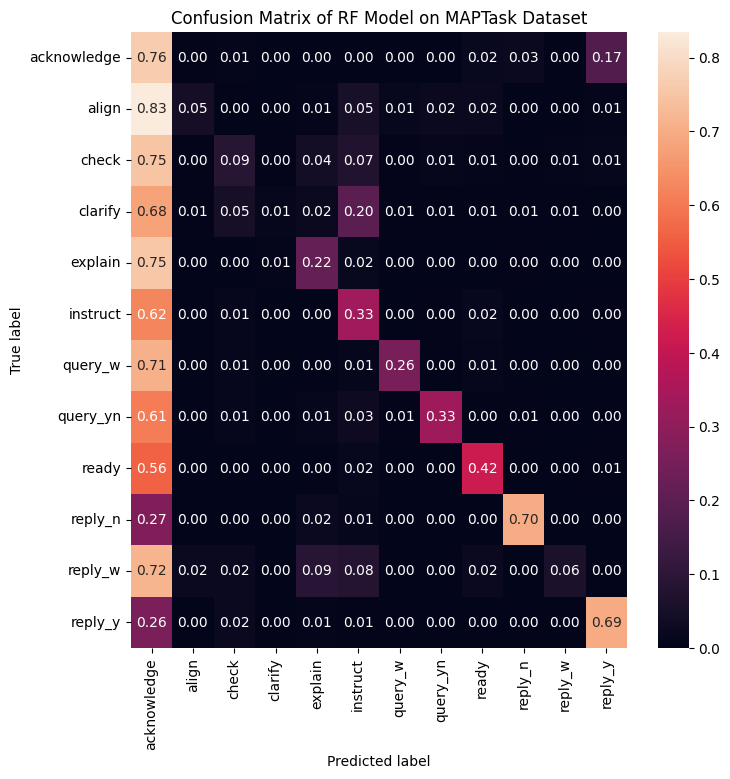

In [23]:
# Plot the confusion matrix of the 12 labels
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# y_pred = model.predict(test_dataset.batch(batch_size))
y_pred = test_preds
y_pred = np.argmax(y_pred, axis=1)
y_test_plot = np.argmax(test_labels, axis=1)

cm = confusion_matrix(y_test_plot, y_pred)
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(8, 8))
plt.title('Confusion Matrix of RF Model on MAPTask Dataset')
sns.heatmap(cm, annot=True, fmt='.2f', xticklabels=dataset["train"].features["Label"].names, yticklabels=dataset["train"].features["Label"].names)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()